In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
#build the vocabulary of characters and mappings to/from integes

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length : how many characters do we take to predict the next one
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xte.shape, Yte.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [36]:
# MLP revisited

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn(vocab_size, n_embd, generator=g)
W1 = torch.randn(n_embd*block_size, n_hidden, generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn(n_hidden, vocab_size, generator=g) *0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


11897


In [37]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g) #picks up random 32 samples from training set
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden pre activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    #track stats
    if i%10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break



      0/ 200000 : 3.3135


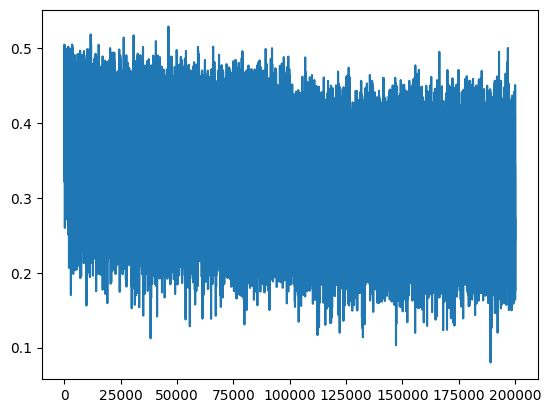

In [19]:
plt.plot(lossi)

In [20]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # hidden layer N * n_hidden
    logits = h @ W2 + b2 # output layer N, vocab_size
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.067592144012451
val 2.1304144859313965


In [21]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0]* block_size
    while True:
        emb = C[torch.tensor([context])] # 1, block_size, n_embd
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        context = context[1:]+ [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out]))


carmahza.
jahmer.
kimri.
reet.
khalaysie.
mahnin.
amerynciereni.
nellara.
chaiir.
kaleigh.
ham.
poin.
quinthorlen.
alvin.
quinterri.
jaryxitza.
eviirud.
mel.
edi.
abette.


In [22]:
# What should be the initial loss
- torch.tensor(1/27.0).log()  
# but it starts with somewhere around 28. 
# Can we do better initialization of weights to overcome this issue ?

tensor(3.2958)

In [23]:
# the issue

logits_extreme = torch.randn(4) * 10
logits_sensible = torch.randn(4)

probs_s = torch.softmax(logits_sensible, dim = 0)
loss_s = -probs_s[2].log()


probs_e = torch.softmax(logits_extreme, dim = 0)
loss_e = -probs_e[2].log()
loss_s, loss_e

# solution
# Make the logits to be near zero to avoid huge losses.
# Initialize the b2 bias to be zero and W2 weights to be close to zero.

(tensor(1.3445), tensor(-0.))

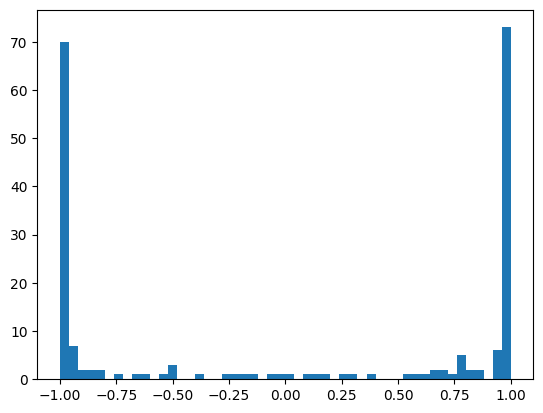

In [24]:
plt.hist(h.view(-1).tolist(), 50);

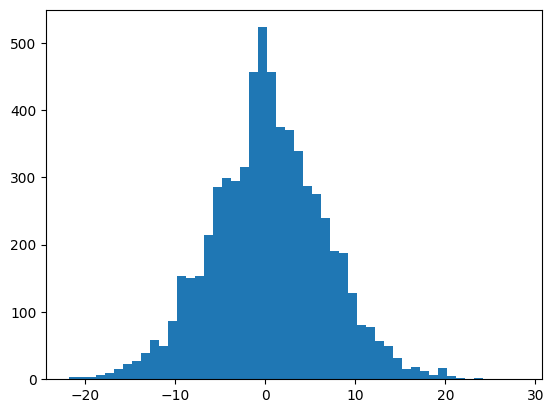

In [25]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [26]:
# Recall the tanh from micrograd
def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self,), 'tanh')
    def _backward():
        self.grad+=(1-t**2) * out.grad
    out._backward = _backward


# As you see the tanh activations are mainly -1.0 and 1.0 , 
# This will make zero updates to the gradient and hence no learning will be 
# happening in these parameters , This is called Saturation of gradients


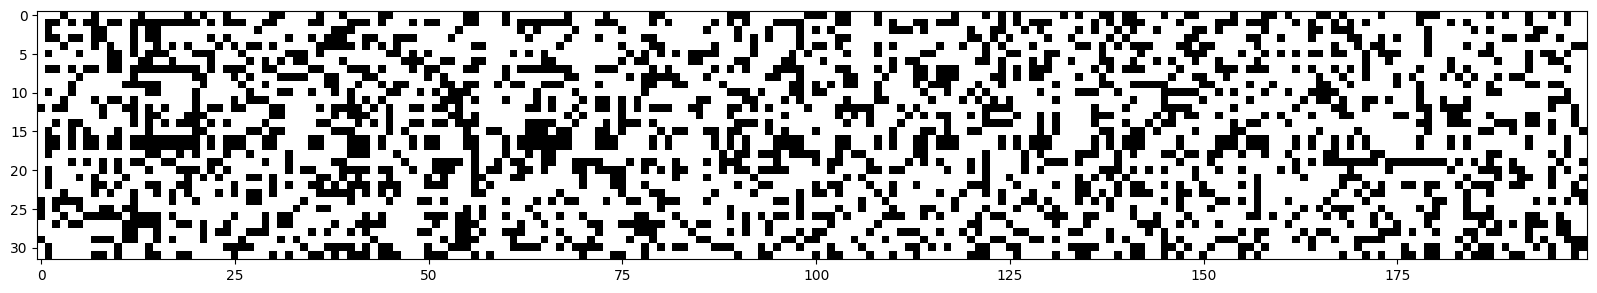

In [32]:
plt.figure(figsize=(20,20))
plt.imshow(h.abs()>0.99 , cmap ='gray', interpolation='nearest')

In [ ]:
# The number of saturation in the neurons is denoted by white dots, which indicate dead neurons.

# The solution again here is to use initialization of the weights properly, so that h values are distributed rather than saturated.

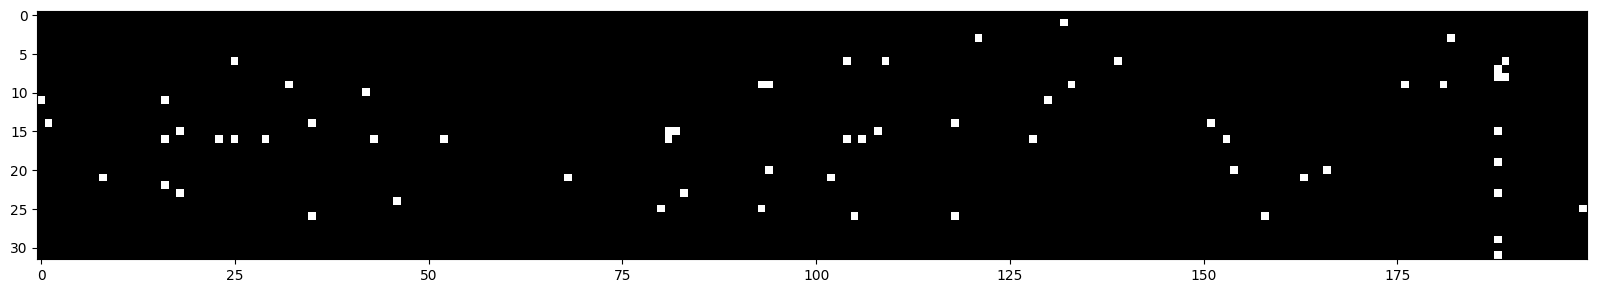

In [38]:
# after initialization of weights w1 and b1
plt.figure(figsize=(20,20))
plt.imshow(h.abs()>0.99 , cmap ='gray', interpolation='nearest')

tensor(-0.0024) tensor(0.9938)
tensor(-0.0023) tensor(3.1592)


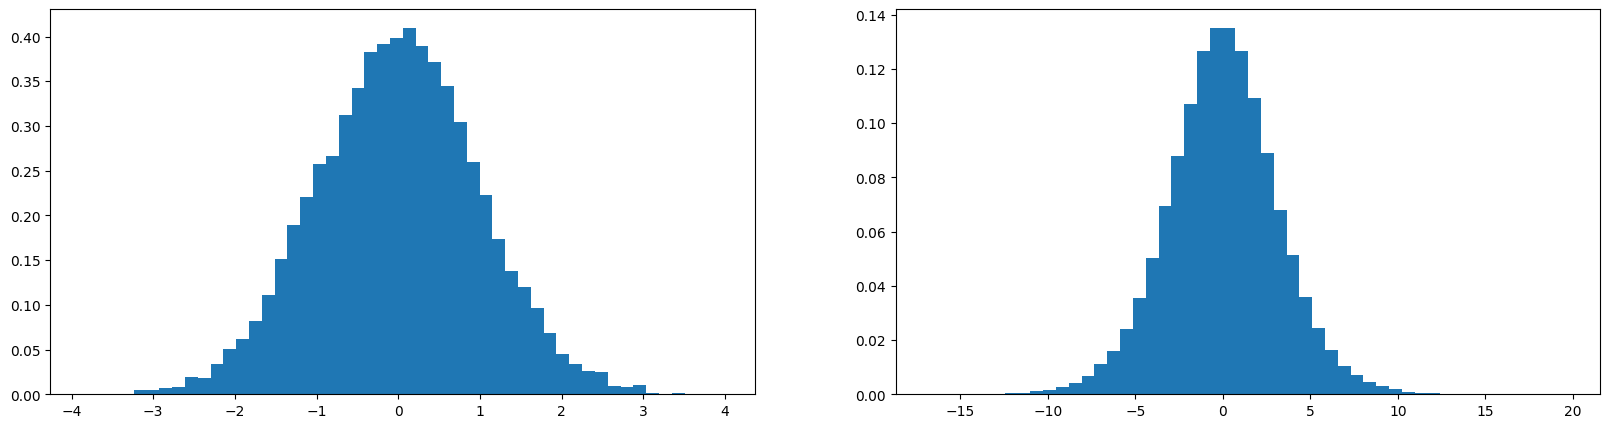

In [39]:
# Now the initialization values are some magic numbers, which we cannot come up with , lets 
# find some principle way to initialize our weights

x = torch.randn(1000, 10)
w = torch.randn(10, 200)

y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize= (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50 , density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50 , density=True);


In [40]:
# if you see in the above plot the y values standard deviation is more , there are varied values more and 
# more , we have to avoid this otherwise we will face saturation of some neurons
# One way to avoid this using Kaiming Initialization , divide the weights by square root of fan_in paramter
# which is nothing but the input parameter of the w


tensor(-0.0057) tensor(1.0025)
tensor(-0.0043) tensor(0.9929)


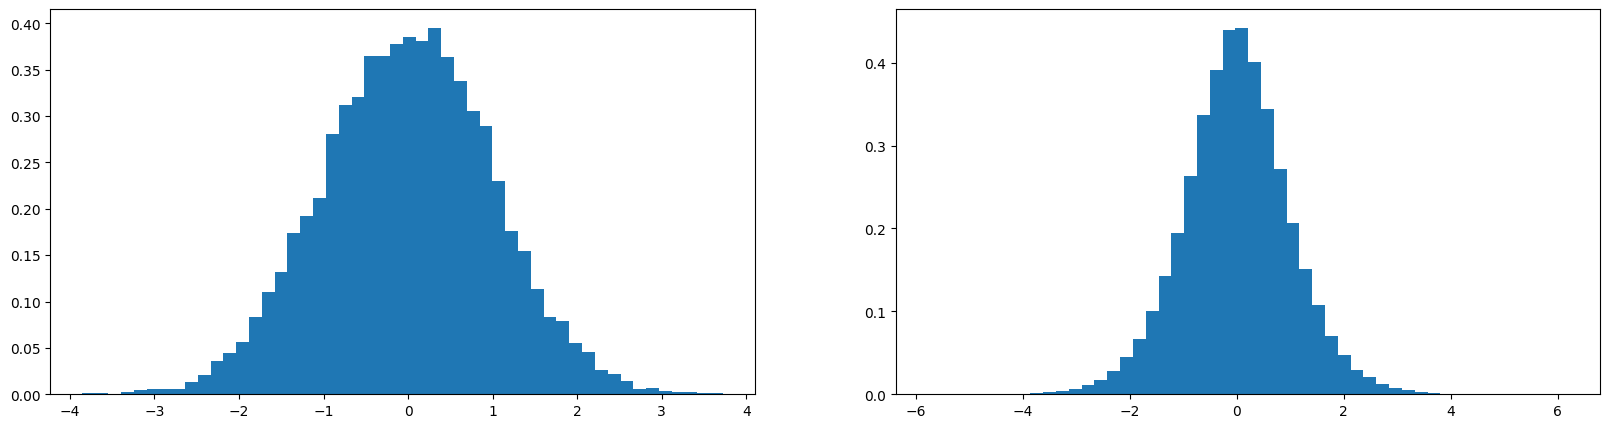

In [41]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5

y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize= (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50 , density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50 , density=True);

In [ ]:
# Now if you see they are very close to each other.

##### Batch Normalization

If you want to have your preactivations normalized another way to acheive that is using batch normalization, very simple idea but very effective

In [53]:
# MLP revisited

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn(vocab_size, n_embd, generator=g)
W1 = torch.randn(n_embd*block_size, n_hidden, generator=g) * (5/3)*((n_embd*block_size)**0.5) # 5/3 is the gain for tanh as per Kaiming Initialization
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn(n_hidden, vocab_size, generator=g) *0.01
b2 = torch.randn(vocab_size, generator=g) * 0


# we need these parameters because we dont want to 
# restrict the model to only be a normalized distribution, 
#Let data dictate whichever distribution the model comes up with
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden)) 
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


12297


In [54]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g) #picks up random 32 samples from training set
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden pre activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True) # batch standard deviation
    hpreact = bngain * (hpreact - bnmeani) / bnstd + bnbias # normalize the hidden layer

    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bnmeani
        bn_std_running = 0.999 * bn_std_running + 0.001 * bnstdi
        
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    #track stats
    if i%10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000 : 3.3117
  10000/ 200000 : 2.2316
  20000/ 200000 : 2.4308
  30000/ 200000 : 2.5056
  40000/ 200000 : 1.9423
  50000/ 200000 : 2.5213
  60000/ 200000 : 2.3866
  70000/ 200000 : 2.1265
  80000/ 200000 : 2.3965
  90000/ 200000 : 2.1806
 100000/ 200000 : 2.1817
 110000/ 200000 : 2.3666
 120000/ 200000 : 2.0529
 130000/ 200000 : 2.4863
 140000/ 200000 : 2.5201
 150000/ 200000 : 2.3524
 160000/ 200000 : 1.9891
 170000/ 200000 : 1.8443
 180000/ 200000 : 2.2242
 190000/ 200000 : 1.9768


In [55]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain* (hpreact - bn_mean_running) / bn_std_running + bnbias # normalize the hidden layer
    h = torch.tanh(hpreact) # hidden layer N * n_hidden
    logits = h @ W2 + b2 # output layer N, vocab_size
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.17462420463562
val 2.190502643585205


In [ ]:
# sometimes we forget to do batch normalization for validation set, the other way to do it is 
# in the same training loop.

In [56]:
# Pytorchinfying the code

In [79]:
class Linear:
    def __init__(self, fan_in , fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out+=self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim , eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum' update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True) # batch mean
            xvar = x.var(0, keepdim = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - momentum) * self.running_mean +  momentum * xmean
                self.running_var = (1 - momentum) * self.running_var +  momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [Linear(n_embd*block_size, n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), Tanh(),
          Linear(n_hidden, vocab_size)
         ]

with torch.no_grad():
    # last layer : make less confident
    layers[-1].weight *= 0.1
    # apply gain for all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *=5/3

parameters =[C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [104]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb , Yb =  Xtr[ix], Ytr[ix]
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i< 100000 else 0.01
    for p in parameters:
        p.data+= -lr * p.grad
    #track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])
    if i==1000 : break

      0/ 200000:2.5413


layer 1 (      Tanh):mean -0.06, std 0.76, saturated : 22.78%
layer 3 (      Tanh):mean +0.03, std 0.74, saturated : 14.78%
layer 5 (      Tanh):mean +0.01, std 0.77, saturated : 17.38%
layer 7 (      Tanh):mean -0.03, std 0.77, saturated : 16.72%
layer 9 (      Tanh):mean -0.01, std 0.72, saturated : 12.25%


Text(0.5, 1.0, 'activation distribution')

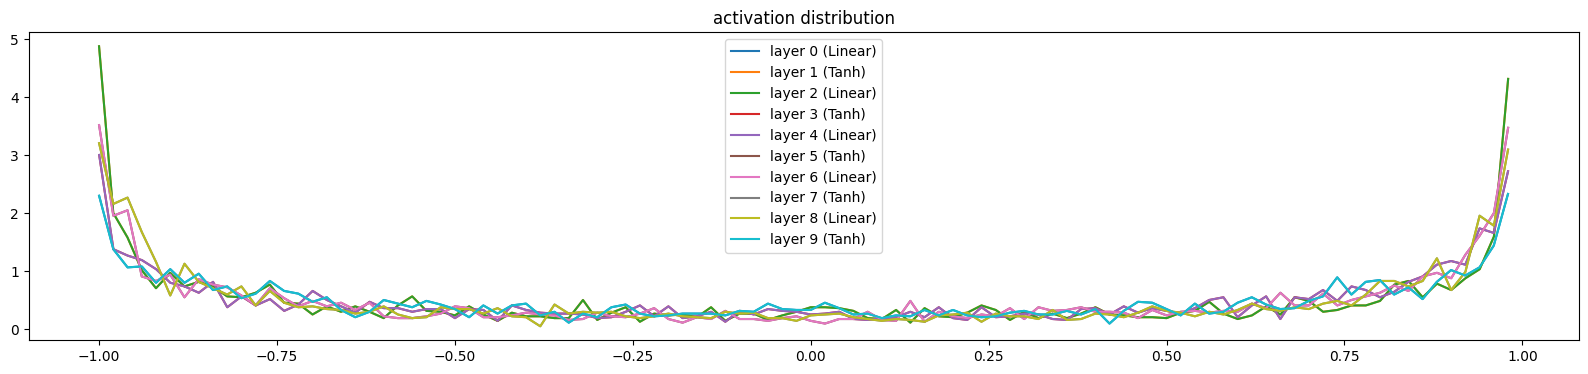

In [106]:
# visualize histograms

plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s):mean %+.2f, std %.2f, saturated : %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
    hy, hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title("activation distribution")

layer 1 (      Tanh):mean +0.00, std 0.00, saturated : 0.00%
layer 3 (      Tanh):mean +0.00, std 0.00, saturated : 0.00%
layer 5 (      Tanh):mean -0.00, std 0.00, saturated : 0.00%
layer 7 (      Tanh):mean -0.00, std 0.00, saturated : 0.00%
layer 9 (      Tanh):mean +0.00, std 0.00, saturated : 0.00%


Text(0.5, 1.0, 'activation distribution')

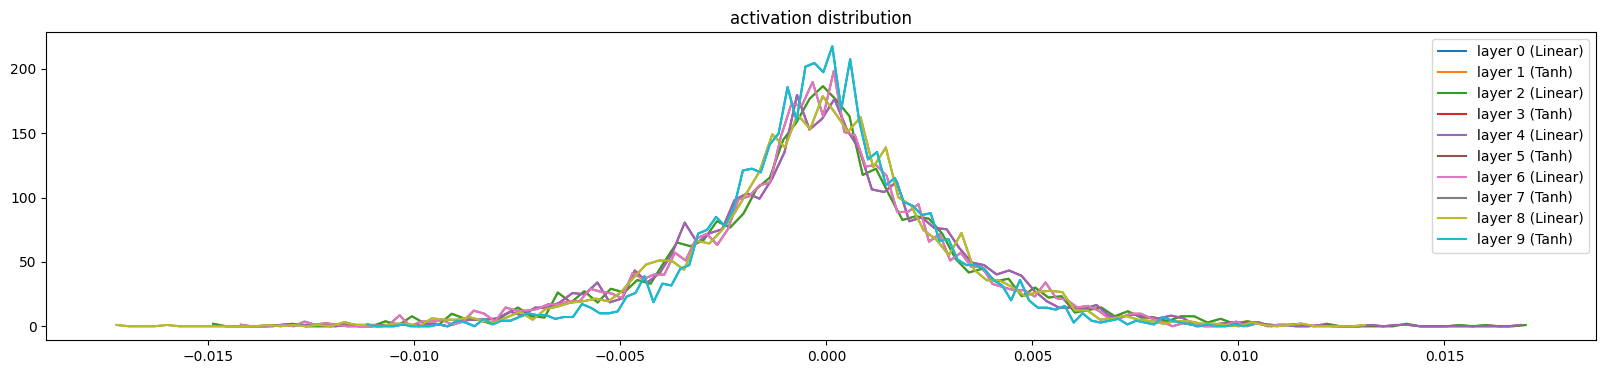

In [101]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s):mean %+.2f, std %.2f, saturated : %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
    hy, hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title("activation distribution")

weight   (27, 10) | mean -0.000110 | std 1.517742e-02 | grad:data ratio 1.505810e-02
weight  (30, 100) | mean +0.000480 | std 1.205572e-02 | grad:data ratio 3.793816e-02
weight (100, 100) | mean -0.000063 | std 8.906814e-03 | grad:data ratio 5.152166e-02
weight (100, 100) | mean -0.000030 | std 8.034817e-03 | grad:data ratio 4.627560e-02
weight (100, 100) | mean +0.000020 | std 7.753496e-03 | grad:data ratio 4.501373e-02
weight (100, 100) | mean -0.000025 | std 7.357999e-03 | grad:data ratio 4.333287e-02
weight  (100, 27) | mean +0.000000 | std 2.364006e-02 | grad:data ratio 2.613824e-01


Text(0.5, 1.0, 'weights gradient distribution')

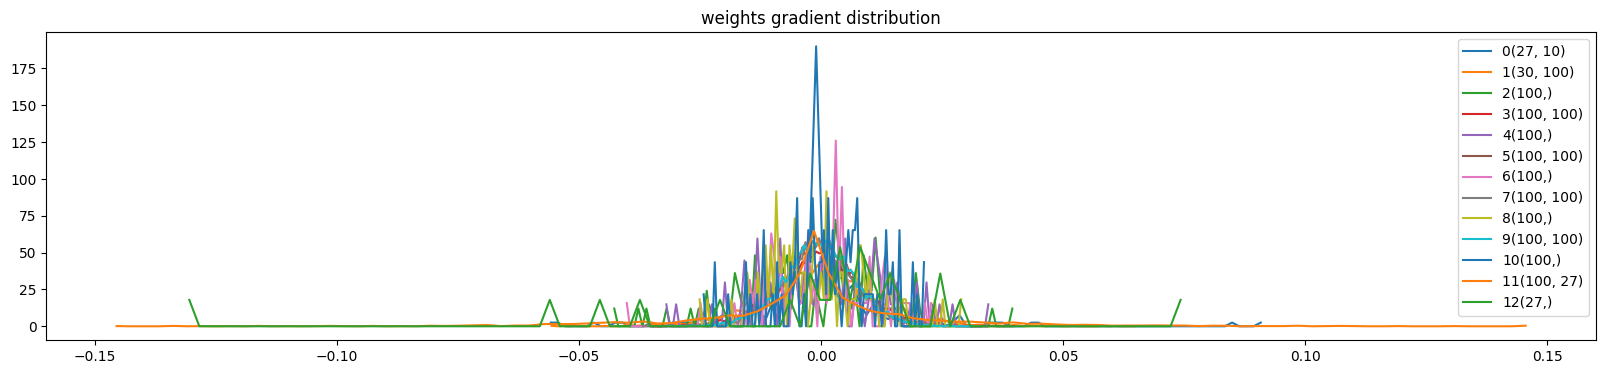

In [107]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim ==2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape),t.mean(), t.std(), t.std()/p.std()))
    hy , hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i}{tuple(p.shape)}')
plt.legend(legends)
plt.title("weights gradient distribution")

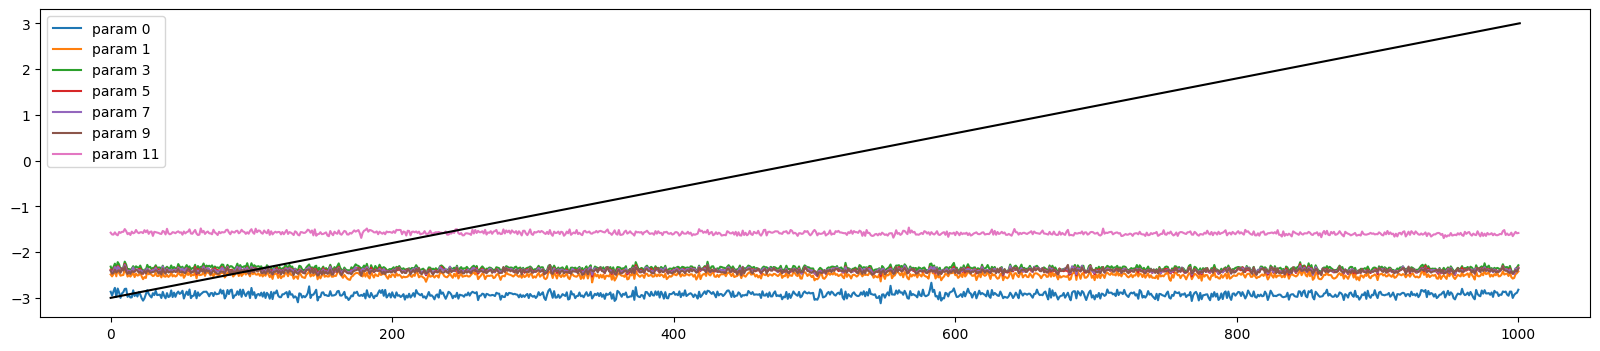

In [111]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, 3], 'k')
plt.legend(legends);

In [115]:
### addding batch norm now

class Linear:
    def __init__(self, fan_in , fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out+=self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim , eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum' update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True) # batch mean
            xvar = x.var(0, keepdim = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean +  self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var +  self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [Linear(n_embd*block_size, n_hidden),BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden, vocab_size)
         ]

with torch.no_grad():
    # last layer : make less confident
    layers[-1].weight *= 0.1
    # apply gain for all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *=5/3

parameters =[C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47497


In [116]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb , Yb =  Xtr[ix], Ytr[ix]
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i< 100000 else 0.01
    for p in parameters:
        p.data+= -lr * p.grad
    #track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])
    if i==1000 : break

      0/ 200000:3.3014


layer 2 (      Tanh):mean -0.00, std 0.63, saturated : 3.47%
layer 5 (      Tanh):mean +0.01, std 0.64, saturated : 3.31%
layer 8 (      Tanh):mean -0.00, std 0.64, saturated : 2.78%
layer 11 (      Tanh):mean +0.00, std 0.65, saturated : 2.19%
layer 14 (      Tanh):mean +0.00, std 0.65, saturated : 2.53%


Text(0.5, 1.0, 'activation distribution')

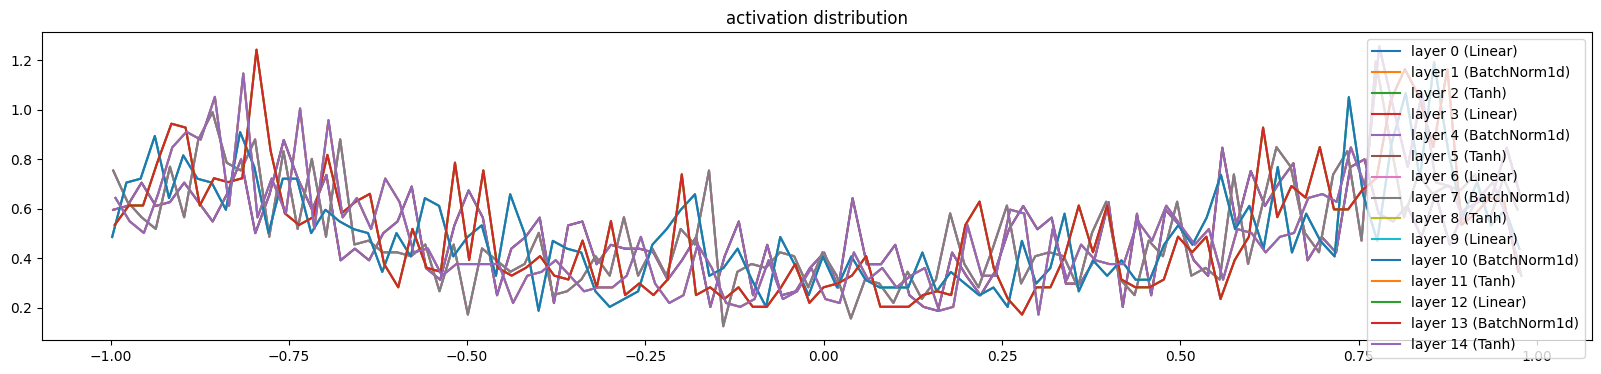

In [118]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s):mean %+.2f, std %.2f, saturated : %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
    hy, hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh):mean -0.00, std 0.00, saturated : 0.00%
layer 5 (      Tanh):mean +0.00, std 0.00, saturated : 0.00%
layer 8 (      Tanh):mean +0.00, std 0.00, saturated : 0.00%
layer 11 (      Tanh):mean -0.00, std 0.00, saturated : 0.00%
layer 14 (      Tanh):mean +0.00, std 0.00, saturated : 0.00%


Text(0.5, 1.0, 'activation distribution')

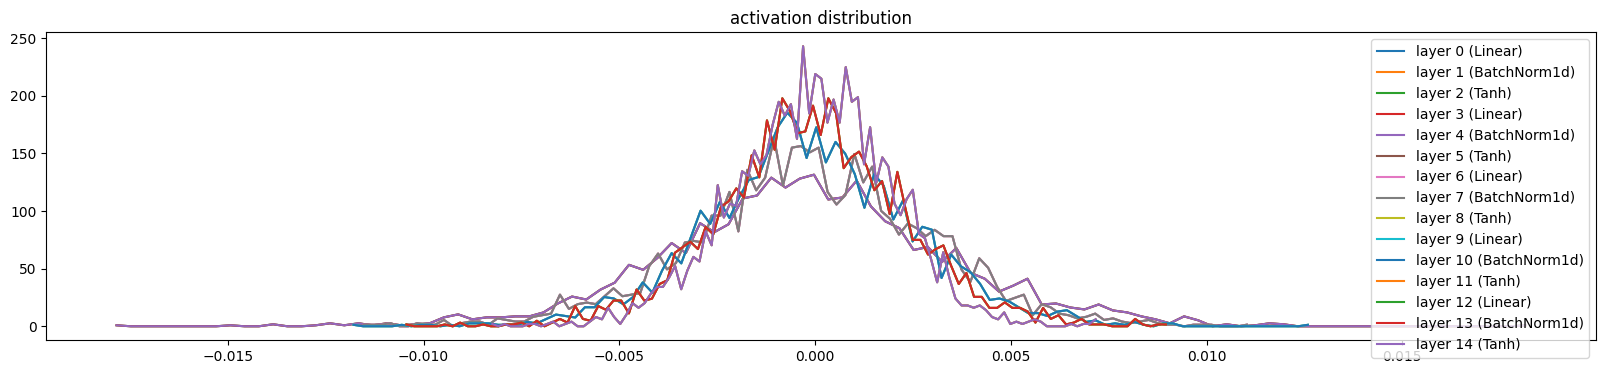

In [120]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s):mean %+.2f, std %.2f, saturated : %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
    hy, hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title("activation distribution")

weight   (27, 10) | mean +0.000000 | std 8.845050e-03 | grad:data ratio 8.834308e-03
weight  (30, 100) | mean +0.000146 | std 8.575281e-03 | grad:data ratio 2.739788e-02
weight (100, 100) | mean -0.000136 | std 6.992015e-03 | grad:data ratio 4.169848e-02
weight (100, 100) | mean -0.000005 | std 5.889201e-03 | grad:data ratio 3.485739e-02
weight (100, 100) | mean -0.000063 | std 5.286868e-03 | grad:data ratio 3.147645e-02
weight (100, 100) | mean +0.000054 | std 4.259468e-03 | grad:data ratio 2.538006e-02
weight  (100, 27) | mean +0.000000 | std 2.214057e-02 | grad:data ratio 3.528603e-01


Text(0.5, 1.0, 'weights gradient distribution')

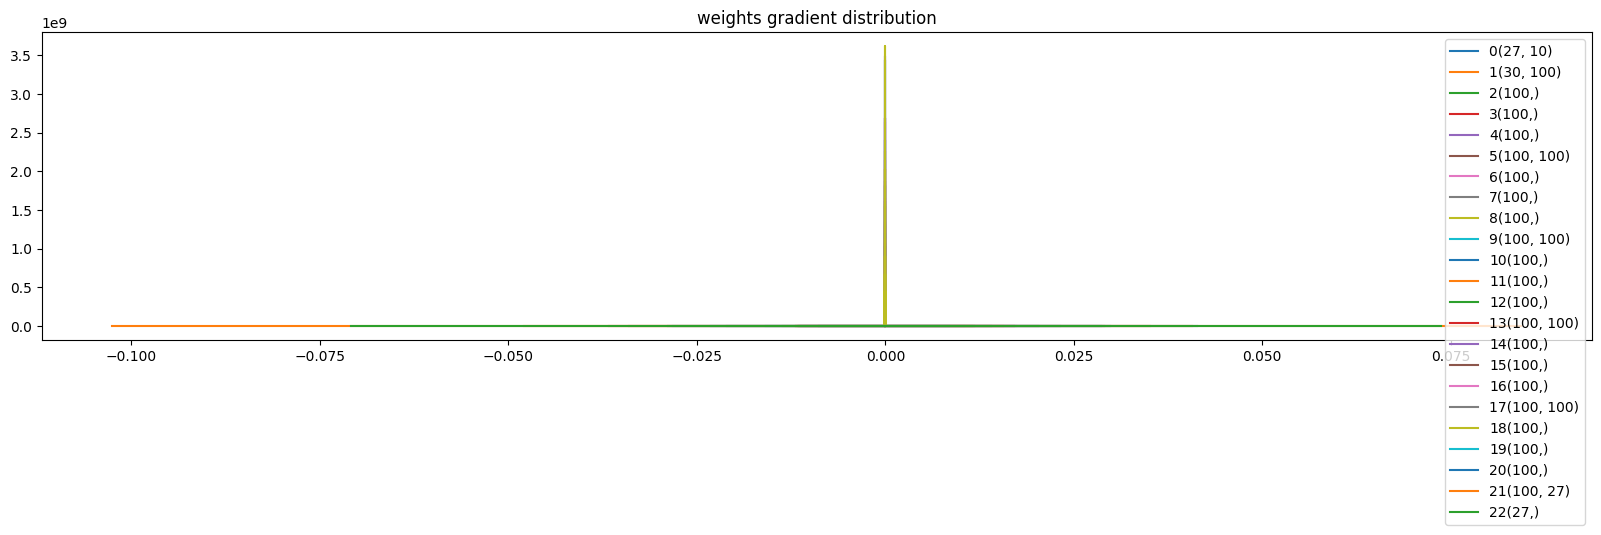

In [122]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim ==2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape),t.mean(), t.std(), t.std()/p.std()))
    hy , hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i}{tuple(p.shape)}')
plt.legend(legends)
plt.title("weights gradient distribution")

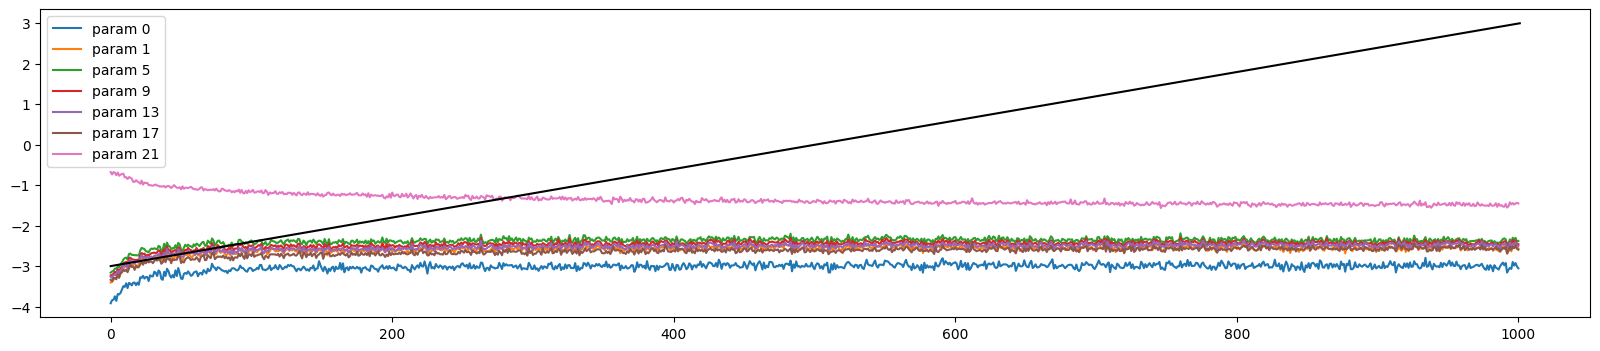

In [123]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, 3], 'k')
plt.legend(legends);